In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE= 256
BATCH_SIZE= 32
CHANNELS = 3

In [4]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Git hub Projects/Potato Disease Classification/Potato Disease Classification",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

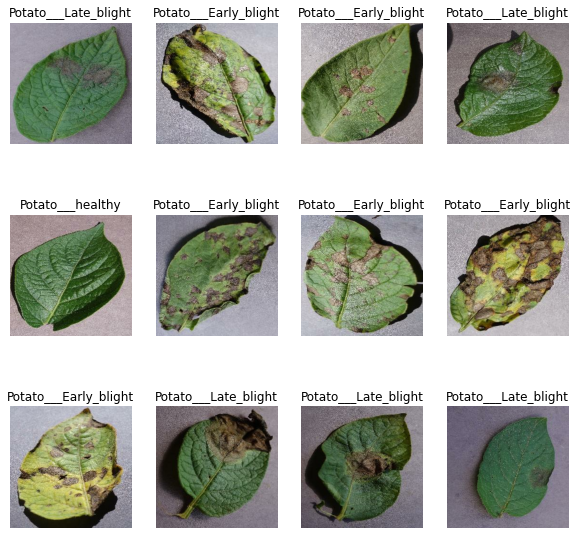

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
#making a function for spliting the data in trian, validation and test
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+val_split+test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size= int(val_split*ds_size)
        
    train_ds = ds.take(train_size)# just the training data
    val_ds = ds.skip(train_size).take(val_size)# removing the train and only val
    test_ds = ds.skip(train_size).skip(val_size)#taking only the remaing the data
        
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [10]:
len(train_ds)

54

In [11]:
len(val_ds)

6

In [12]:
len(test_ds)

8

In [13]:
train_ds =train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x,training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size= (3,3), activation ='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
    
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data= val_ds,
    verbose = 1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 168s 435ms/step - loss: 0.8884 - accuracy: 0.5156 - val_loss: 0.7761 - val_accuracy: 0.5365
Epoch 2/50
54/54 [==============================] - 18s 330ms/step - loss: 0.7198 - accuracy: 0.6562 - val_loss: 0.5295 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 18s 334ms/step - loss: 0.5311 - accuracy: 0.7610 - val_loss: 0.5461 - val_accuracy: 0.7708
Epoch 4/50
54/54 [==============================] - 18s 333ms/step - loss: 0.4374 - accuracy: 0.8131 - val_loss: 0.4014 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 18s 329ms/step - loss: 0.3726 - accuracy: 0.8432 - val_loss: 0.2719 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 18s 329ms/step - loss: 0.2819 - accuracy: 0.8825 - val_loss: 0.2465 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 18s 331ms/step - loss: 0.2336 - accuracy: 0.9057 - val_loss: 0.2795 - val_accuracy: 0.895

In [21]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 6s 62ms/step - loss: 0.0216 - accuracy: 0.9922


In [22]:
scores

[0.021592313423752785, 0.9921875]

In [23]:
history

In [24]:
history.params

{'epochs': 50, 'steps': 54, 'verbose': 1}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
len(history.history['loss'])

50

In [27]:
history.history['loss'][:5]

[0.8884361982345581,
 0.7198441028594971,
 0.5310559868812561,
 0.43736907839775085,
 0.3726251721382141]

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [29]:
EPOCHS =  range(50)

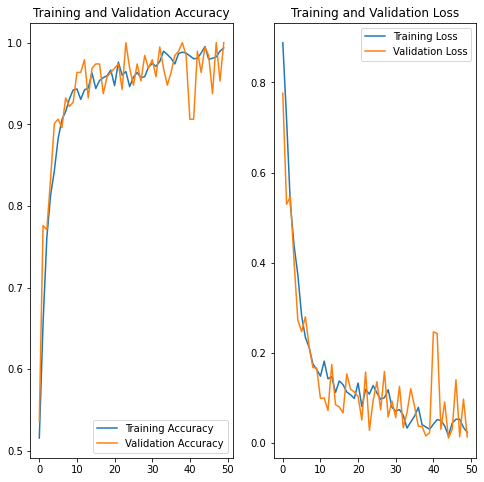

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(EPOCHS, acc, label='Training Accuracy')
plt.plot(EPOCHS, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(EPOCHS, loss, label='Training Loss')
plt.plot(EPOCHS, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual_label Potato___Early_blight
prediction label Potato___Early_blight


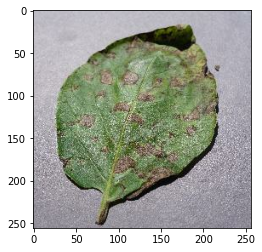

In [31]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print("actual_label",class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("prediction label",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

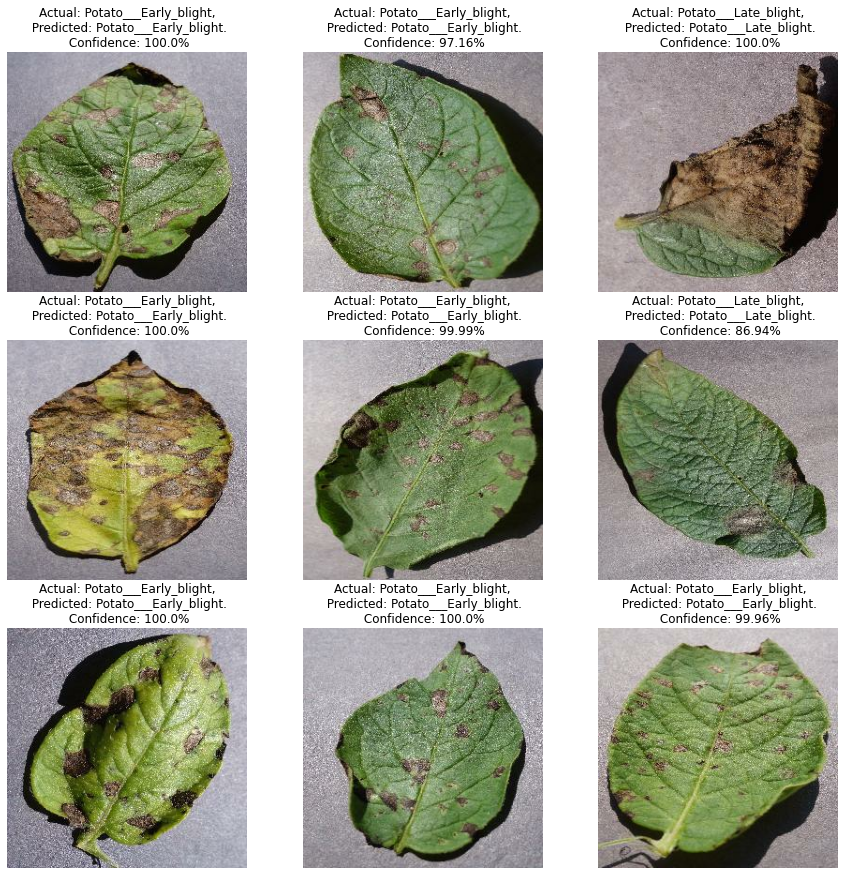

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
import os
model.save(f"../content/drive/MyDrive/Git hub Projects/Potato Disease Classification")

INFO:tensorflow:Assets written to: ../content/drive/MyDrive/Git hub Projects/Potato Disease Classification/assets
